## DATASET SETUP

In [130]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [131]:
image_size = (224,224)

In [132]:
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3057, 0.3193, 0.3037],
                     std=[0.2876, 0.2850, 0.2894])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3057, 0.3193, 0.3037],
                     std=[0.2876, 0.2850, 0.2894])
])

In [133]:
# Create PyTorch datasets for training and validation
train_dataset = datasets.ImageFolder(root='../input/CNN_landscape/Train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='../input/CNN_landscape/Validation', transform=test_transform)
test_dataset = datasets.ImageFolder(root='../input/CNN_landscape/Test', transform=test_transform)

# Create PyTorch dataloaders for training and validation
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [134]:
class_dict = {}
for idx, label in enumerate(train_dataset.classes):
    class_dict[idx] = label

print(class_dict)


{0: 'Coast', 1: 'Desert', 2: 'Forest', 3: 'Glacier', 4: 'Mountain'}


In [135]:
def visualise_img(dataloader, class_dict: dict):
    """
    Function to visualize the first 9 images of the dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_dict (dict): Dictionary mapping class indices to class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_dict[label]}', loc='left')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


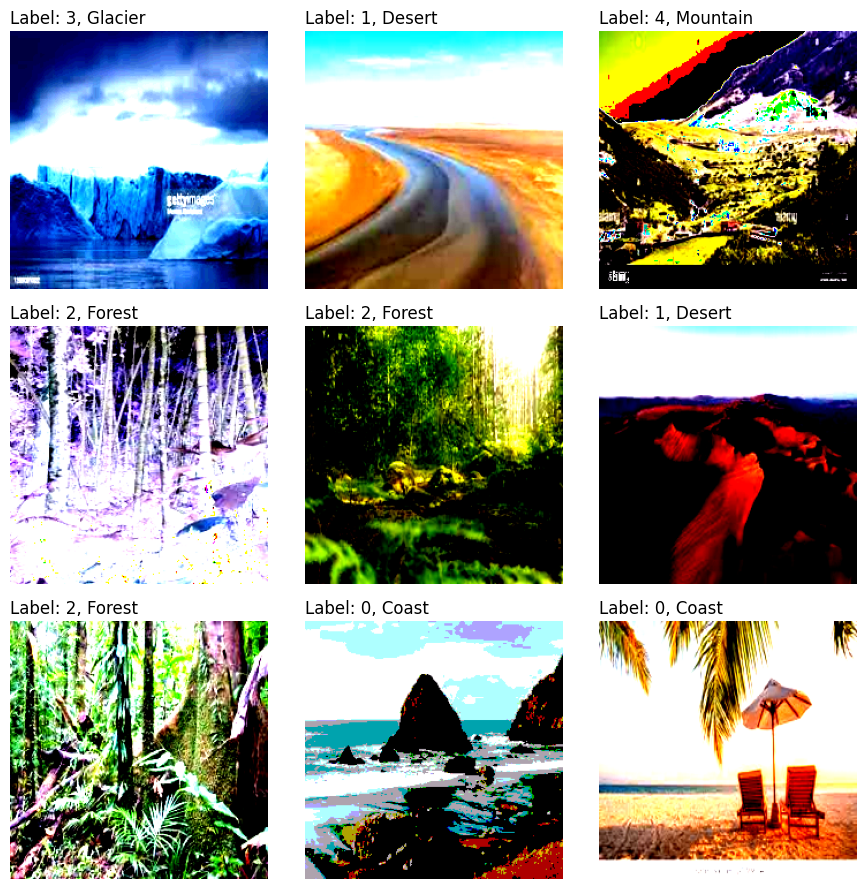

In [136]:
visualise_img(train_dataloader, class_dict)

## TRAIN AND EVAL

In [137]:
def eval(model, criterion, val_dataloader, device):
  model.eval()

  val_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for image, label in val_dataloader:
      image = image.to(device)
      label = label.to(device)

      outputs = model(image)
      loss = criterion(outputs, label)
      val_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      total += label.size(0)
      correct += (predicted == label.to('cuda')).sum().item()

  accuracy = (correct / total) * 100
  avg_val_loss = val_loss / len(val_dataloader)

  return accuracy, avg_val_loss


In [138]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, device, model_name):
  train_loss = []
  val_loss = []
  for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    for image, label in tqdm(train_dataloader):
      image = image.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      outputs = model(image)
      loss = criterion(outputs, label)
      loss.backward()
      optimizer.step()
      training_loss += loss.item()

    epoch_loss = training_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

    accuracy, avg_val_loss = eval(model, criterion, val_dataloader, device)
    print(f"Validation loss: {avg_val_loss}, Validation Accuracy: {accuracy:.2f}")

    train_loss.append(epoch_loss)
    val_loss.append(avg_val_loss)

    if len(val_loss) > 1 and val_loss[-1] < min(val_loss[:-1]):
      torch.save(model, f'../models/cnn/{model_name}_best.pt')
      print("Best model saved")

  torch.save(model, f'../models/cnn/{model_name}_{num_epochs}.pt')
  return train_loss, val_loss




In [140]:
#Clearing GPU memory

import gc
torch.cuda.empty_cache()
gc.collect()

0

## INCEPTIONV3

In [64]:
class InceptionV3(torch.nn.Module):
    def __init__(self, class_dict, num_unfreeze):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        self.inception.fc = torch.nn.Linear(self.inception.fc.in_features, len(class_dict.keys()))
        self.inception.aux_logits = False

        for param in self.inception.parameters():
          param.requires_grad = False

        
        # for name, param in self.inception.named_parameters():
        #     if name in ['fc.weight', 'fc.bias']:
        #         param.requires_grad = True

        parameters = list(self.inception.parameters())
        for param in parameters[-num_unfreeze:]:
          param.requires_grad = True
        
        # print(list(self.inception.parameters())[-4:])

    def forward(self, images):
        features = self.inception(images)

        return features

### Training Linear Layer

In [106]:
model = InceptionV3(class_dict, 2).to('cuda') #2 for fc weights and bias

In [107]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'incept_1')

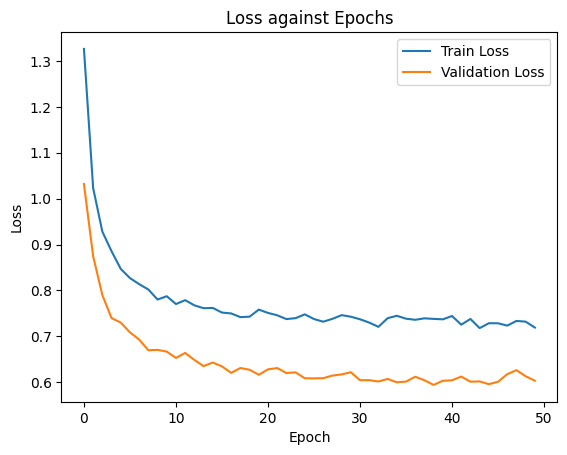

In [110]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Training last 10 layers

In [111]:
model = InceptionV3(class_dict, 10).to('cuda')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

In [88]:
model = InceptionV3(class_dict, 10).to('cuda')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'incept_10')

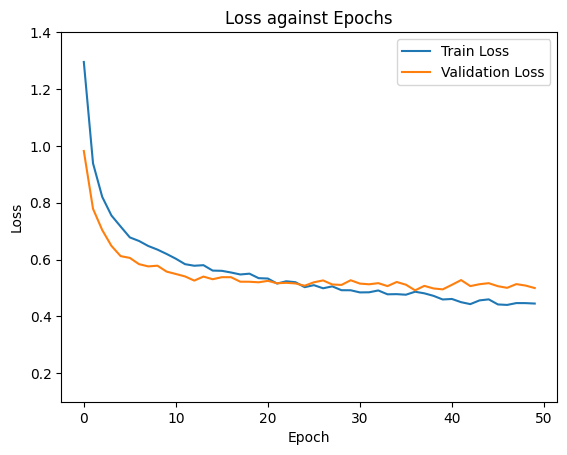

In [90]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')
plt.ylim([0.1, 1.4])

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Evaluation

In [128]:
best_model = torch.load('../models/cnn/resnet50/resnet_20_50.pt')

In [129]:
accuracy, avg_test_loss = eval(best_model,
                             criterion,
                             test_dataloader,
                              'cuda')

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 92.2, test_loss: 0.2575994823127985


## RESNET50

In [11]:
class ResNet50(torch.nn.Module):
    def __init__(self, class_dict, num_unfreeze):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, len(class_dict.keys()))

        for param in self.resnet.parameters():
          param.requires_grad = False

        parameters = list(self.resnet.parameters())
        for param in parameters[-num_unfreeze:]:
          param.requires_grad = True

    def forward(self, images):
        features = self.resnet(images)

        return features

### Training Linear Layer

In [12]:
model = ResNet50(class_dict, 2).to('cuda')

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'resnet_1')

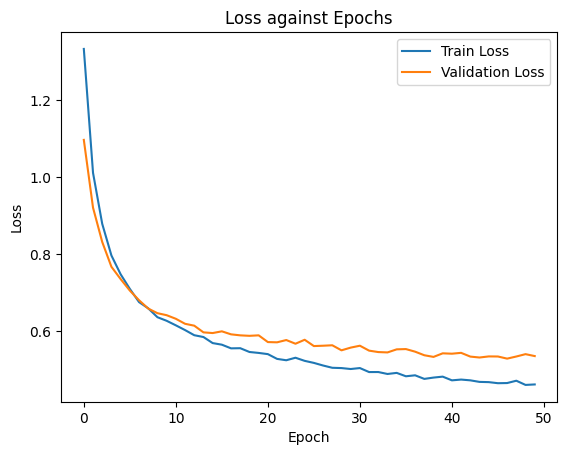

In [15]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Adding legend
plt.legend()
plt.ylim([0.1, 1.4])

# Displaying the plot
plt.show()


### Training last 15 layers

In [39]:
model = ResNet50(class_dict, 15).to('cuda')

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'resnet_20')

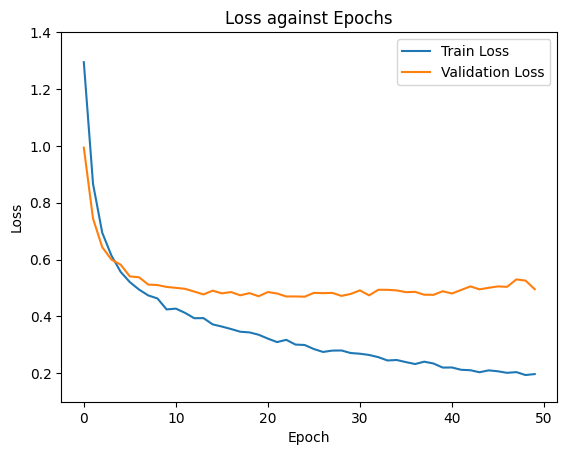

In [53]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')
plt.ylim([0.1, 1.4])

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


In [158]:
best_model = torch.load('../models/cnn/resnet_152_30.pt')

In [159]:
accuracy, avg_test_loss = eval(best_model,
                             criterion,
                             test_dataloader,
                              'cuda')

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 90.0, test_loss: 0.25748731940984726
